In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score
import datetime
from pylab import rcParams
import warnings
from pandas.core.nanops import nanmean as pd_nanmean
import random 
from random import shuffle
from sklearn.metrics import mean_absolute_error


## Первичный анализ данных

Цель проекта:
проанализировать датасет, выявить закономерности, проверить поставленные гипотезы и построить прогноз на основе наблюдений из прошлого.



Анализируемый датасет представляет из себя отчеты об инцидентах с преступностью в Бостоне за 2015-2018г., которые используются, чтобы задокументировать первоначальные подробности инцидента, на которые реагируют сотрудники BPD. Это набор данных, содержащий записи из новой системы отчетов о происшествиях с преступностью, которая включает в себя сокращенный набор полей, предназначенных для регистрации типа происшествия, а также того, когда и где он произошел.

Датасет взят из Kaggle.https://www.kaggle.com/AnalyzeBoston/crimes-in-boston/version/1

In [2]:
dataset = pd.read_csv('crime.csv',header=0,encoding = 'unicode_escape')
dataset.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


Поля в исходной таблице говорят о местоположении, времени и типе преступления. Типы переменных: object, int64, float64

### Предобработка данных

Удалим лишние поля, и преобразуем данные, чтобы изучить зависимость количества преступлений за каждый день от времени

In [3]:
dataset['data']=[str(dataset['OCCURRED_ON_DATE'][i]).split(' ')[0] for i in range(dataset.shape[0])]

In [4]:
value = pd.DataFrame()
value['value'] = dataset['data']
data = pd.DataFrame(value['value'].value_counts()).sort_index()

### Визуальный анализ данных

посмотрим на исходный ряд

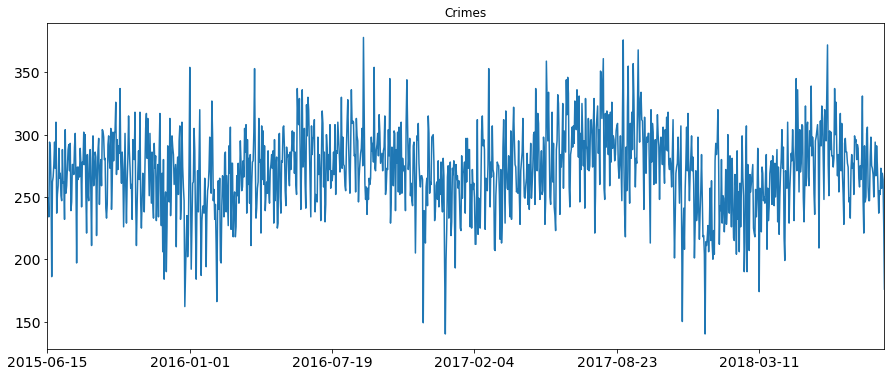

In [5]:
data.value.plot( figsize=(15,6),title= 'Crimes', fontsize=14)

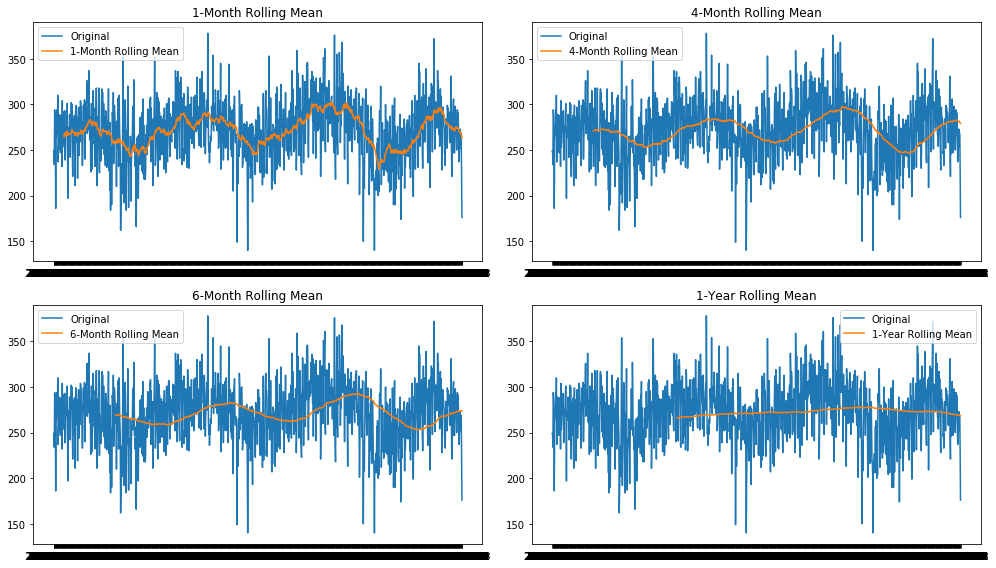

In [6]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window = 30
axes[0][0].plot(data.index, data, label='Original')
axes[0][0].plot(data.index, data.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[0][0].set_title("1-Month Rolling Mean")
axes[0][0].legend(loc='best')

window = 30*4
axes[0][1].plot(data.index, data, label='Original')
axes[0][1].plot(data.index, data.rolling(window=window).mean(), label='4-Month Rolling Mean')
axes[0][1].set_title("4-Month Rolling Mean")
axes[0][1].legend(loc='best')

window = 6*30
axes[1][0].plot(data.index, data, label='Original')
axes[1][0].plot(data.index, data.rolling(window=window).mean(), label='6-Month Rolling Mean')
axes[1][0].set_title("6-Month Rolling Mean")
axes[1][0].legend(loc='best')

window = 12*30
axes[1][1].plot(data.index, data, label='Original')
axes[1][1].plot(data.index, data.rolling(window=window).mean(), label='1-Year Rolling Mean')
axes[1][1].set_title("1-Year Rolling Mean")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

определим сезонность визуально по графику и разложим по аддитивной модели

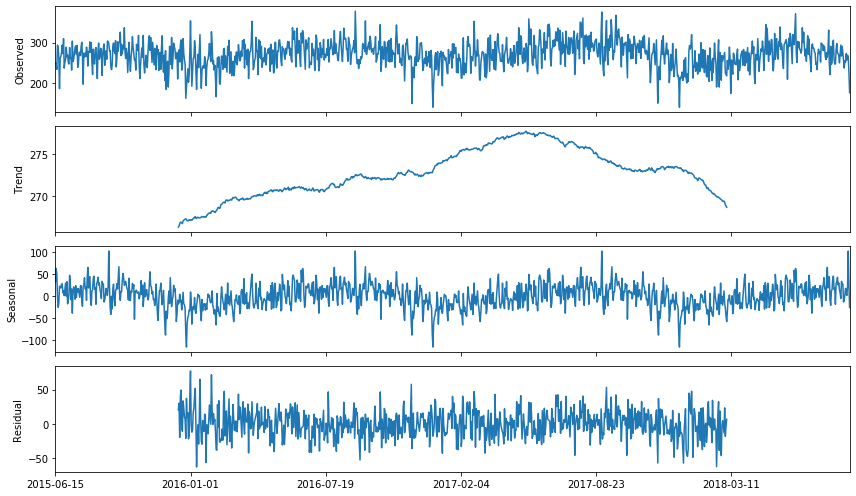

In [7]:
rcParams['figure.figsize'] = 12, 7
decompos = sm.tsa.seasonal_decompose(data.value, model="additive",freq=365)
decompos.plot()
plt.show()

In [8]:
if sm.tsa.adfuller(data.value)[1] > 0.05:
    print('ряд стационарный')
else:
    print('ряд нестационарный')    

ряд нестационарный


Итак, можно заметить, что количество преступлений увеличивается к середине года и уменьшается зимой.

Теперь обратим внимание на тренд, преступность росла в течение 2015 и 2016 года, но к середине 2017 начала стремительно падать, возможно были приняты меры органами власти или была улучшена социальная ситуация.

### Предобработка данных

Изучим данные в зависимости от вида преступления, обратим внимание на несколько самых встречаемых в Бостоне.

In [265]:
data_groups = pd.DataFrame(dataset['OFFENSE_CODE_GROUP'].value_counts())

In [266]:
data_groups.sort_values(by=['OFFENSE_CODE_GROUP'])
data_groups[:10]

,OFFENSE_CODE_GROUP
Motor Vehicle Accident Response,37132
Larceny,25935
Medical Assistance,23540
Investigate Person,18750
Other,18075
Drug Violation,16548
Simple Assault,15826
Vandalism,15415
Verbal Disputes,13099
Towed,11287


In [267]:
def obr(dataset1,name):
    dataset_name = pd.DataFrame(dataset1[dataset1['OFFENSE_CODE_GROUP']==name])
    value1 = pd.DataFrame()
    value1['value'] = dataset_name['data']
    data1 = pd.DataFrame(value1['value'].value_counts()).sort_index()
    return data1

### Визуализация данных

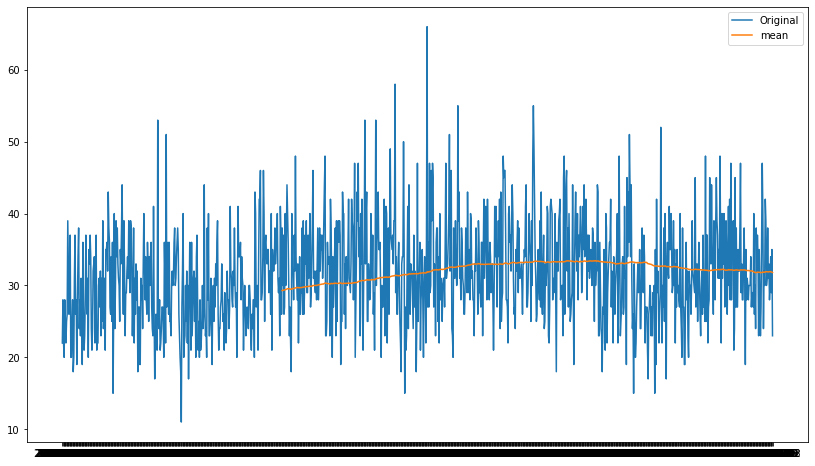

In [273]:
data_avar=obr(dataset,'Motor Vehicle Accident Response')

fig, axes = plt.subplots(1, 1)
fig.set_figwidth(14)
fig.set_figheight(8)
axes.plot(data_avar.index,data_avar, label='Original')
axes.plot(data_avar.rolling(window=365).mean(), label='mean')
plt.legend(loc='best')
plt.show()

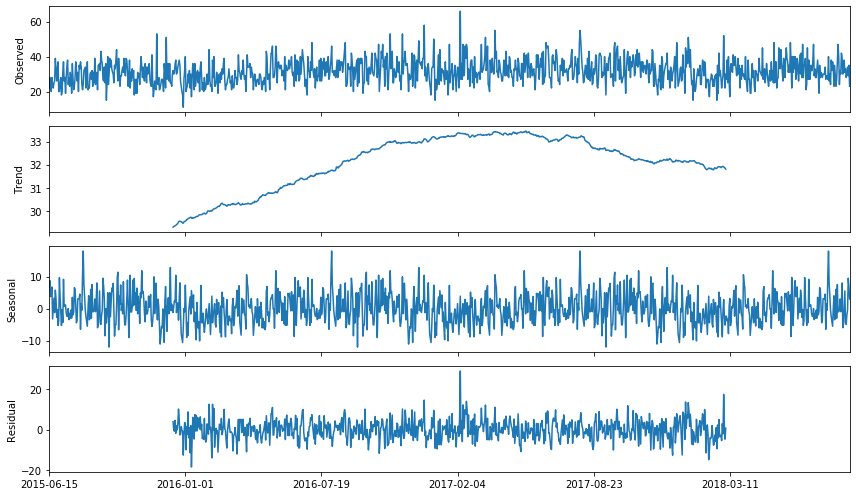

In [269]:

rcParams['figure.figsize'] = 12, 7
decompos = sm.tsa.seasonal_decompose(data_avar, model="additive",freq=365)
decompos.plot()
plt.show()

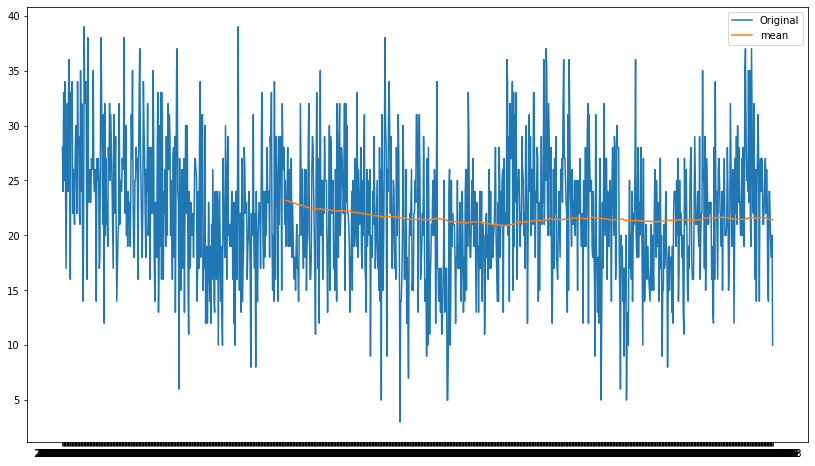

In [275]:
data_larceny=obr(dataset,'Larceny')

fig, axes = plt.subplots(1, 1)
fig.set_figwidth(14)
fig.set_figheight(8)
axes.plot(data_larceny.index,data_larceny, label='Original')
axes.plot(data_larceny.rolling(window=365).mean(), label='mean')
plt.legend(loc='best')
plt.show()

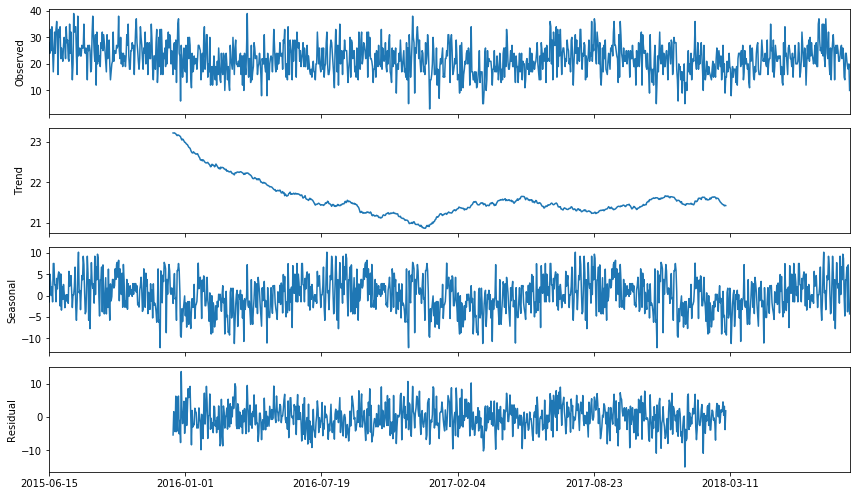

In [271]:
rcParams['figure.figsize'] = 12, 7
decompos = sm.tsa.seasonal_decompose(data_larceny, model="additive",freq=365)
decompos.plot()
plt.show()

Можно заметить,что сезонность не сильно отличается от общего случая, количество аварий выросло со временем, а количество краж наоборот уменьшилось.

### Посторение прогноза на 2 следующих месяца

In [86]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


/home/lubov/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


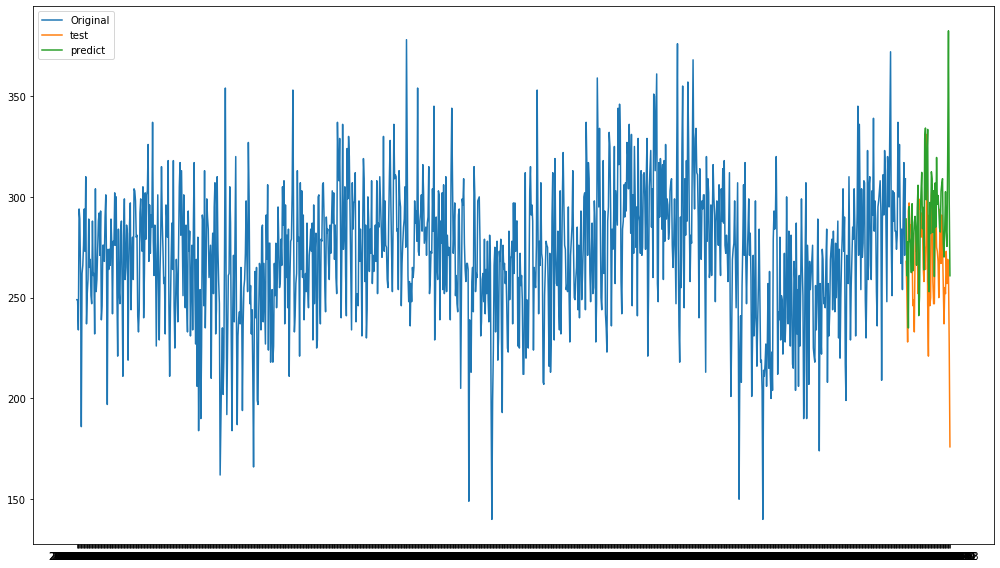

In [111]:
train = data[:-30*2]
test = data[-30*2:]
forecast = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train) ,seasonal_periods=365 ,trend='add', seasonal='add',).fit()
forecast = pd.Series(fit1.forecast(len(test)))
forecast.index = test.index

fig, axes = plt.subplots(1, 1)
fig.set_figwidth(14)
fig.set_figheight(8)
axes.plot(data.index[:-30*2],train, label='Original')
axes.plot(data.index[-30*2:],test, label='test')
axes.plot(data.index[-30*2:],forecast, label='predict')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Проверка статистических гипотез

In [158]:
from statsmodels.stats.descriptivestats import sign_test

Используем непараметрический критерий, так как непараметрические критерии не требуют соответствия какому-либо из распределений. 

Гипотеза H0 состоит в том, что разница между количеством преступлений во вторник и пятницу статистически не значима

$ H0: P(X_1 > X_2) = \frac{1} {2}$

$ H1: P(X_1 > X_2) <> \frac{1} {2}$

In [284]:
dataset_name = pd.DataFrame(dataset[dataset['DAY_OF_WEEK']=='Tuesday'])
value1 = pd.DataFrame()
value1['value'] = dataset_name['data']
data_tuesday = pd.DataFrame(value1['value'].value_counts()).sort_index()

In [285]:
dataset_name = pd.DataFrame(dataset[dataset['DAY_OF_WEEK']=='Friday'])
value1 = pd.DataFrame()
value1['value'] = dataset_name['data']
data_friday = pd.DataFrame(value1['value'].value_counts()).sort_index()


d=np.array(data_friday.value)
d2=np.array(data_tuesday.value)

In [286]:
df = pd.DataFrame()

df['friday'] = d
df['tuesday'] = d2
df['stat_M'] = np.where(df.friday > df.tuesday,1,0)
df.head()

,friday,tuesday,stat_M
0,289,249,1
1,273,266,1
2,269,259,1
3,304,261,1
4,293,288,1


In [287]:
N_plus = df.stat_M.sum()
N_minus = df.shape[0] - N_plus

In [288]:
M = (N_plus - N_minus)/2
M

24.0

In [289]:
sign_test(df.friday - df.tuesday)

(24.5, 0.0001848966278192461)

Гипотеза H0 отвергается, количество преступлений в пятницу больше, чем во вторник.

## Заключение

Итак, мы узнали, что
- количество преступлений увеличивается к середине года и уменьшается зимой.
- преступность росла в течение 2015 и 2016 года, но к середине 2017 начала стремительно падать.
- количество аварий выросло со временем.
- количество краж уменьшилось.
- количество преступлений в пятницу больше, чем во вторник.
